In [20]:
import os
import glob
import torch
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import peak_signal_noise_ratio as psnr
from monai.metrics import DiceMetric
from models import CycleTransMorph, SpatialTransformer
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm.notebook import tqdm

BASE_PATH = "/mnt/hot/public/Akul/exhale_pred_data"
INSP_PATH = os.path.join(BASE_PATH, "inhale")
EXP_PATH = os.path.join(BASE_PATH, "exhale")
INSP_MASK_PATH = os.path.join(BASE_PATH, "masks", "inhale")
EXP_MASK_PATH = os.path.join(BASE_PATH, "masks", "exhale")
MODEL_PATH = "./model_runs/ctm_run_1/best_model.pth"

IMG_SIZE = (128, 128, 128)
BATCH_SIZE = 1
DEVICE = torch.device("cuda")

In [21]:
class LungDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        paths = self.file_paths[idx]
        return {
            'insp': torch.from_numpy(np.load(paths['insp'])).float().unsqueeze(0),
            'exp': torch.from_numpy(np.load(paths['exp'])).float().unsqueeze(0),
            'insp_mask': torch.from_numpy(np.load(paths['insp_mask'])).float().unsqueeze(0),
            'exp_mask': torch.from_numpy(np.load(paths['exp_mask'])).float().unsqueeze(0)
        }

patient_ids = [os.path.basename(p).replace('.npy', '') for p in glob.glob(os.path.join(INSP_PATH, "*.npy"))]
patient_ids.sort()
all_files = [{'insp': os.path.join(INSP_PATH, f"{pid}.npy"), 'exp': os.path.join(EXP_PATH, f"{pid}.npy"), 'insp_mask': os.path.join(INSP_MASK_PATH, f"{pid}_INSP_mask.npy"), 'exp_mask': os.path.join(EXP_MASK_PATH, f"{pid}_EXP_mask.npy")} for pid in patient_ids]

split_idx = int(0.9 * len(all_files))
val_files = all_files[split_idx:]

test_dataset = LungDataset(val_files)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total processed samples: {len(all_files)}")
print(f"Using {len(test_dataset)} samples for testing (10% validation set).")

Total processed samples: 8702
Using 871 samples for testing (10% validation set).


In [22]:
model = CycleTransMorph(img_size=IMG_SIZE).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True))
model.eval()
transformer = SpatialTransformer(size=IMG_SIZE).to(DEVICE)

In [4]:
dice_metric = DiceMetric(include_background=True, reduction="mean")

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Calculating Soft Dice Scores"):
        inhale_img = batch['insp'].to(DEVICE)
        exhale_img = batch['exp'].to(DEVICE)
        inhale_mask = batch['insp_mask'].to(DEVICE)
        exhale_mask = batch['exp_mask'].to(DEVICE)

        _, dvf, _ = model(inhale_img, exhale_img)        
        pred_exhale_mask = transformer(inhale_mask, dvf)
        dice_metric(y_pred=pred_exhale_mask, y=exhale_mask)

mean_dice = dice_metric.aggregate().item()
print(f"  Average Dice Score: {mean_dice:.4f}")

Calculating Soft Dice Scores:   0%|          | 0/871 [00:00<?, ?it/s]

  Average Dice Score: 0.6772


In [5]:
psnr_scores = []
mae_scores = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Calculating PSNR/MAE"):
        inhale_img = batch['insp'].to(DEVICE)
        exhale_img = batch['exp'].to(DEVICE)

        pred_exhale_img, _, _ = model(inhale_img, exhale_img)

        pred_np = pred_exhale_img.squeeze().cpu().numpy()
        gt_np = exhale_img.squeeze().cpu().numpy()
        
        data_range = gt_np.max() - gt_np.min()
        psnr_scores.append(psnr(gt_np, pred_np, data_range=data_range))
        mae_scores.append(np.mean(np.abs(gt_np - pred_np)))

avg_psnr = np.mean(psnr_scores)
avg_mae = np.mean(mae_scores)

print(f"  Average PSNR: {avg_psnr:.4f} dB")
print(f"  Average MAE: {avg_mae:.4f}")

Calculating PSNR/MAE:   0%|          | 0/871 [00:00<?, ?it/s]

  Average PSNR: 14.3538 dB
  Average MAE: 0.1004


In [6]:
def get_jacobian_determinant(dvf):
    # Permute to (H, W, D, 3) for np.gradient
    dvf_numpy = dvf.squeeze().permute(1, 2, 3, 0).cpu().numpy()
    
    # Get gradients of each displacement component
    grad_x_du = np.gradient(dvf_numpy[..., 0], axis=0)
    grad_y_dv = np.gradient(dvf_numpy[..., 1], axis=1)
    grad_z_dw = np.gradient(dvf_numpy[..., 2], axis=2)

    # Construct the Jacobian matrix.
    J = np.zeros(dvf_numpy.shape + (3,))
    J[..., 0, 0] = 1 + grad_x_du
    J[..., 0, 1] = np.gradient(dvf_numpy[..., 0], axis=1)
    J[..., 0, 2] = np.gradient(dvf_numpy[..., 0], axis=2)

    J[..., 1, 0] = np.gradient(dvf_numpy[..., 1], axis=0)
    J[..., 1, 1] = 1 + grad_y_dv
    J[..., 1, 2] = np.gradient(dvf_numpy[..., 1], axis=2)

    J[..., 2, 0] = np.gradient(dvf_numpy[..., 2], axis=0)
    J[..., 2, 1] = np.gradient(dvf_numpy[..., 2], axis=1)
    J[..., 2, 2] = 1 + grad_z_dw

    return np.linalg.det(J)

non_positive_jacobians = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Calculating Jacobians"):
        inhale_img = batch['insp'].to(DEVICE)
        exhale_img = batch['exp'].to(DEVICE)

        # Predict the DVF
        _, dvf_i_e, _ = model(inhale_img, exhale_img)
        
        # Calculate Jacobian determinant
        jacobian_det = get_jacobian_determinant(dvf_i_e)
        
        # Count non-positive values
        num_non_positive = np.sum(jacobian_det <= 0)
        total_voxels = np.prod(jacobian_det.shape)
        
        percentage = (num_non_positive / total_voxels) * 100
        non_positive_jacobians.append(percentage)

avg_non_positive = np.mean(non_positive_jacobians)

print(f"Average Percentage of Non-Positive Jacobian Values: {avg_non_positive:.6f}%")

Calculating Jacobians:   0%|          | 0/871 [00:00<?, ?it/s]

Average Percentage of Non-Positive Jacobian Values: 0.080976%


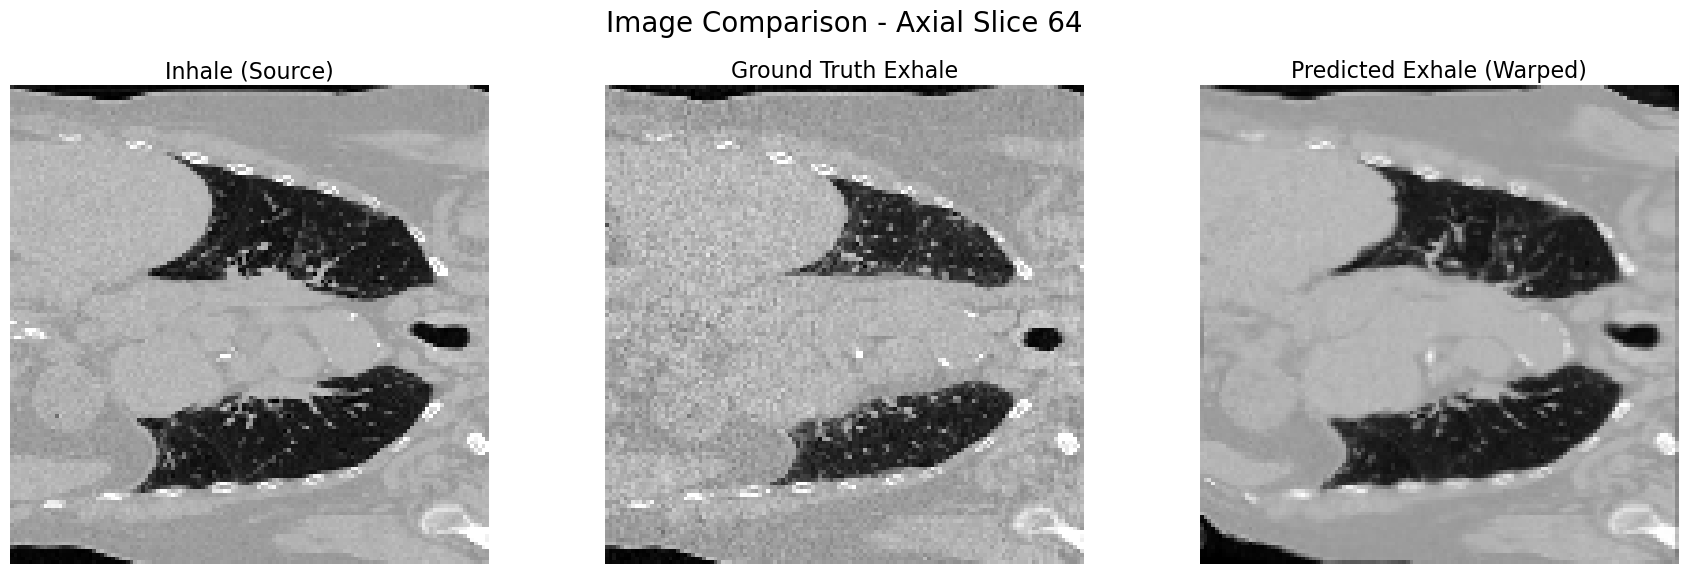

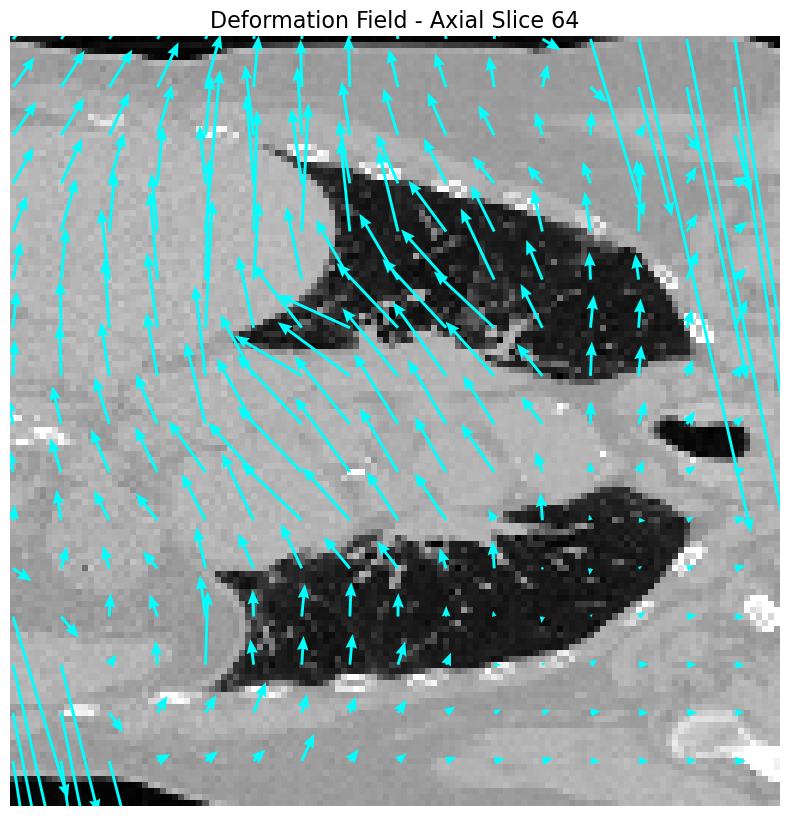

In [7]:
# Get a single sample for visualization
sample_batch = next(iter(test_dataloader))
inhale_img = sample_batch['insp'].to(DEVICE)
exhale_img = sample_batch['exp'].to(DEVICE)

# Run the model to get the outputs
with torch.no_grad():
    warped_exhale, dvf, _ = model(inhale_img, exhale_img)

# Move data to CPU and NumPy for plotting
inhale_np = inhale_img.squeeze().cpu().numpy()
exhale_np = exhale_img.squeeze().cpu().numpy()
warped_np = warped_exhale.squeeze().cpu().numpy()
dvf_np = dvf.squeeze().cpu().numpy()

# Choose a central slice to visualize (e.g., the 64th slice along the z-axis)
slice_idx = 64
inhale_slice = inhale_np[:, slice_idx, :]
exhale_slice = exhale_np[:, slice_idx, :]
warped_slice = warped_np[:, slice_idx, :]

# The DVF has 3 channels (for z, y, x displacement). We'll visualize y and x.
# Note: DVF shape is (3, D, H, W) -> (3, 128, 128, 128)
# We need y-flow (channel 1) and x-flow (channel 2)
dvf_y = dvf_np[1, :, slice_idx, :]
dvf_x = dvf_np[2, :, slice_idx, :]

# --- Plotting ---
plt.style.use('default')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Inhale Image
axes[0].imshow(inhale_slice, cmap='gray')
axes[0].set_title('Inhale (Source)', fontsize=16)
axes[0].axis('off')

# Ground Truth Exhale Image
axes[1].imshow(exhale_slice, cmap='gray')
axes[1].set_title('Ground Truth Exhale', fontsize=16)
axes[1].axis('off')

# Warped (Predicted) Exhale Image
axes[2].imshow(warped_slice, cmap='gray')
axes[2].set_title('Predicted Exhale (Warped)', fontsize=16)
axes[2].axis('off')

plt.suptitle(f'Image Comparison - Axial Slice {slice_idx}', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- Quiver Plot for Deformation Field ---
fig_q, ax_q = plt.subplots(figsize=(10, 10))

# Display the inhale slice as the background
ax_q.imshow(inhale_slice, cmap='gray')

# Downsample the vector field to make the plot readable
skip = 8 # Plot one vector every 8 pixels
x = np.arange(0, dvf_x.shape[1], skip)
y = np.arange(0, dvf_y.shape[0], skip)
X, Y = np.meshgrid(x, y)
u = dvf_x[Y, X]
v = dvf_y[Y, X]

# Plot the vectors (arrows)
ax_q.quiver(X, Y, u, v, color='cyan', angles='xy', scale_units='xy', scale=0.2, headwidth=4)

ax_q.set_title(f'Deformation Field - Axial Slice {slice_idx}', fontsize=16)
ax_q.axis('off')
plt.show()

Loading a sample from the test set...
Running model inference (TEST 1: Swapped Inputs)...
Calling model(exhale, inhale) to get DVF_Inhale->Exhale
Shape of DVF from model: torch.Size([1, 3, 128, 128, 128])
Calculating ventilation map...
Calculation complete.

--- Quantitative Analysis (Inside Lung Mask) ---
Total voxels in lung mask: 166807
Voxels with J > 1 (Expansion): 54781
Percentage of Expanding Voxels: 32.84%
Mean Jacobian: 0.9519
Median Jacobian: 0.9480
--------------------------------------------------

>>> RESULT: This appears to be the correct COMPRESSION field.
Generating orthogonal (3-view) plots...


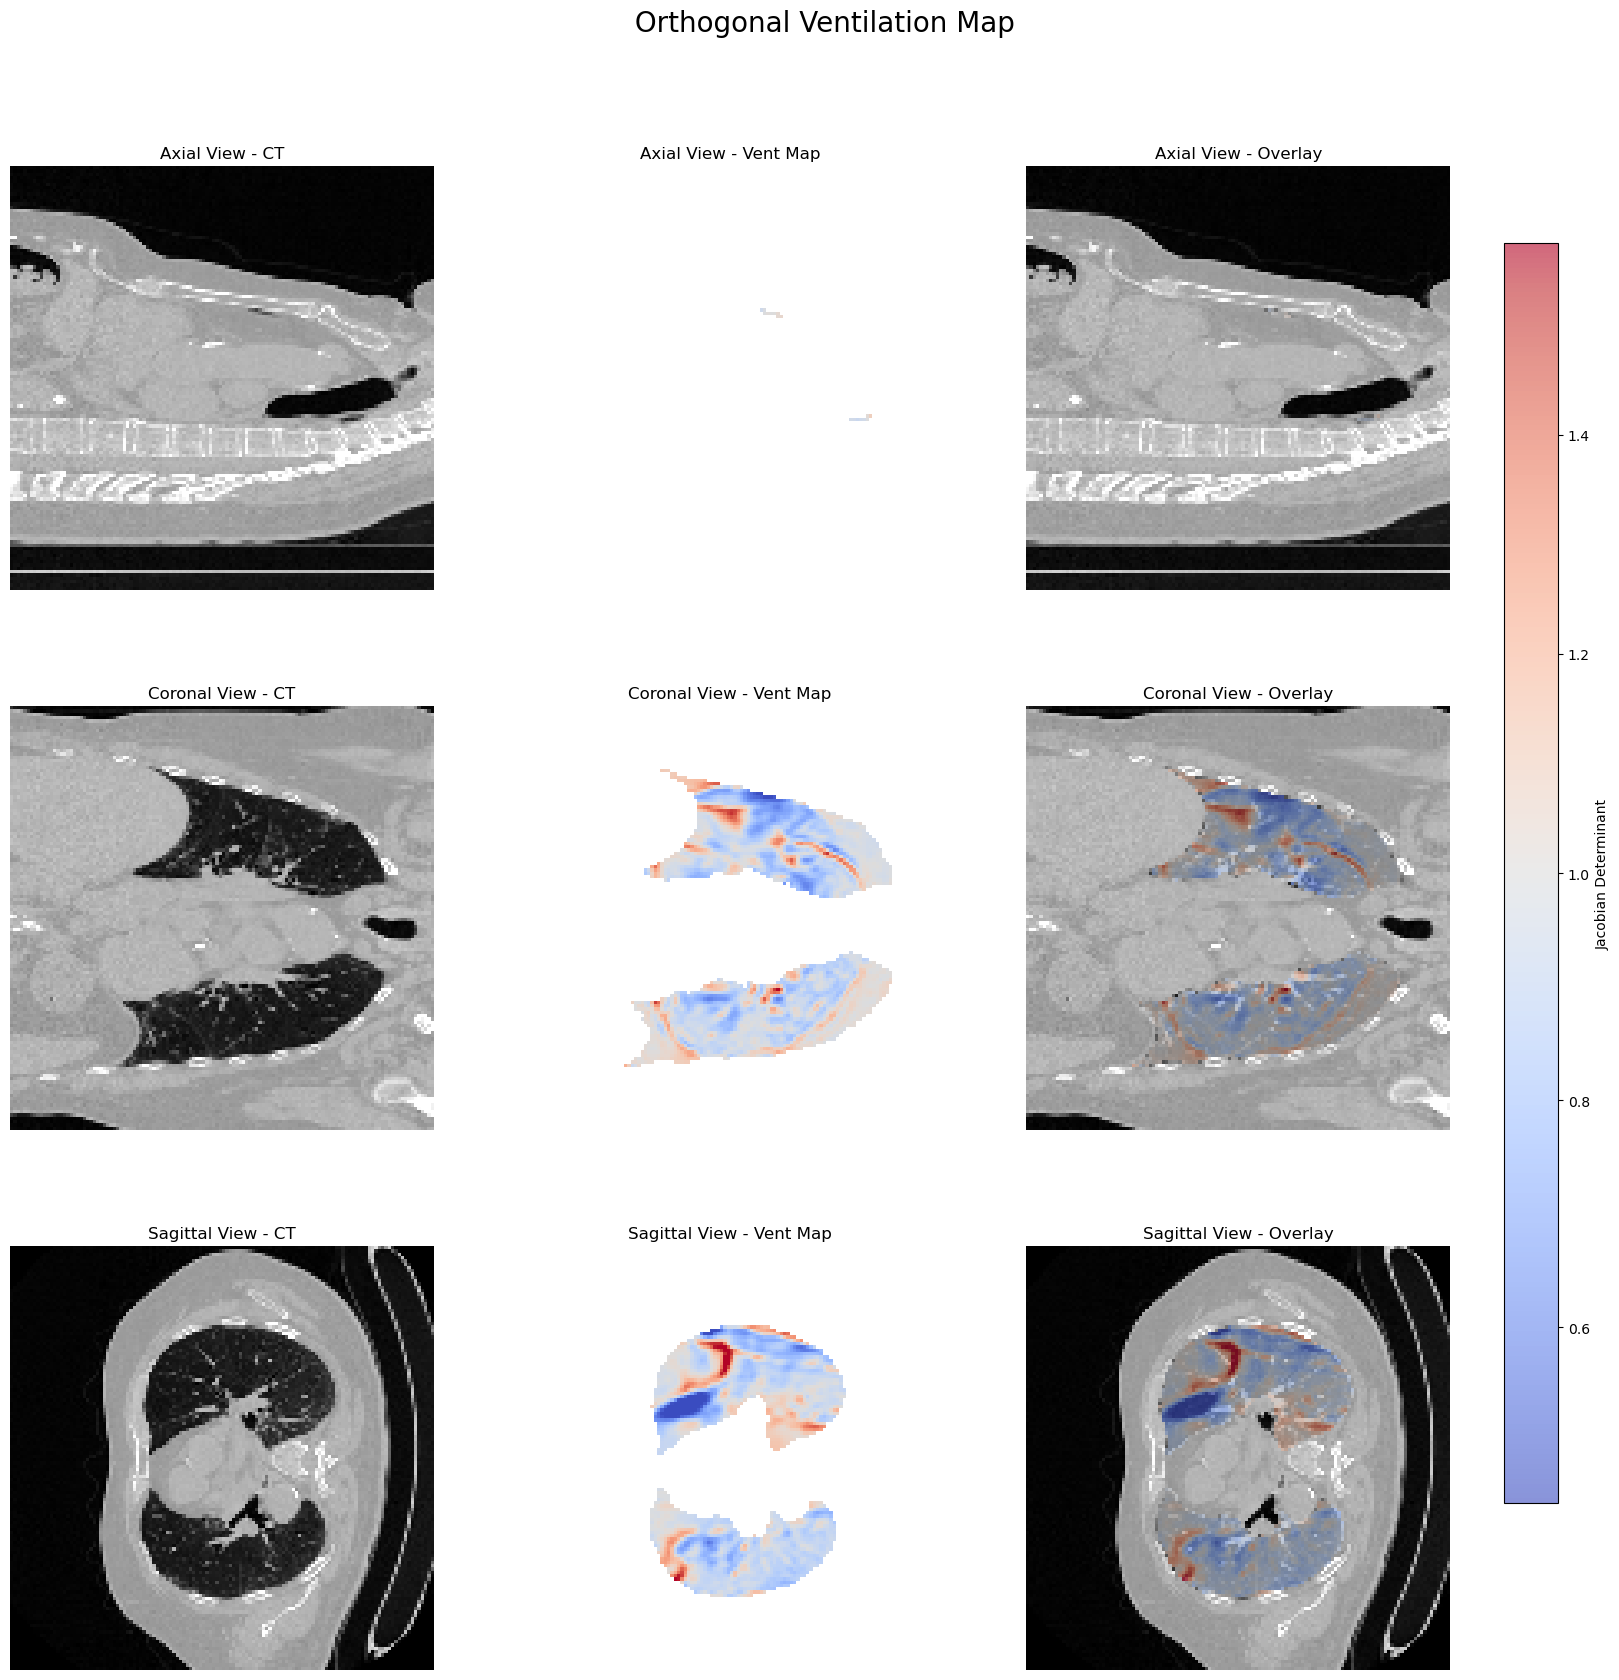

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as colors
# Assuming model, test_dataloader, DEVICE, inhale_img, exhale_img, etc.
# are all correctly loaded from running cells 1-5.

# =====================================================================================
# ## 6. Functional Analysis (Testing for Swapped Inputs)
# =====================================================================================

# --- 1. Helper Function: Calculate Full Jacobian ---
def get_jacobian_determinant(dvf_numpy):
    """ Calculates the full 3D Jacobian determinant. """
    dvf_transposed = np.transpose(dvf_numpy, (1, 2, 3, 0))
    grad_u = np.gradient(dvf_transposed[..., 0]); du_dz, du_dy, du_dx = grad_u[0], grad_u[1], grad_u[2]
    grad_v = np.gradient(dvf_transposed[..., 1]); dv_dz, dv_dy, dv_dx = grad_v[0], grad_v[1], grad_v[2]
    grad_w = np.gradient(dvf_transposed[..., 2]); dw_dz, dw_dy, dw_dx = grad_w[0], grad_w[1], grad_w[2]
    J_11 = 1 + du_dz; J_12 = du_dy; J_13 = du_dx
    J_21 = dv_dz; J_22 = 1 + dv_dy; J_23 = dv_dx
    J_31 = dw_dz; J_32 = dw_dy; J_33 = 1 + dw_dx
    det = J_11 * (J_22 * J_33 - J_23 * J_32) - J_12 * (J_21 * J_33 - J_23 * J_31) + J_13 * (J_21 * J_32 - J_22 * J_31)
    return det

# --- 2. Helper Function: Plot 3-View (Ortho) ---
def plot_ortho_views(vent_map_3d, ct_scan_3d, mask_3d, title_prefix=""):
    """ Generates a 3x3 grid showing Axial, Coronal, and Sagittal views. """
    D, H, W = ct_scan_3d.shape
    slice_d = D // 2; slice_h = H // 2; slice_w = W // 2
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle(f'{title_prefix} Orthogonal Ventilation Map', fontsize=20)
    fig.patch.set_facecolor('white')
    
    masked_vent_3d = np.where(mask_3d > 0, vent_map_3d, np.nan)
    if np.all(np.isnan(masked_vent_3d)): print("Warning: 3D lung mask empty."); return
    v_min = np.nanpercentile(masked_vent_3d, 1); v_max = np.nanpercentile(masked_vent_3d, 99)
    if v_min == v_max: v_max += 1e-6
    cmap = 'coolwarm'; norm = colors.TwoSlopeNorm(vmin=v_min, vcenter=1.0, vmax=v_max)
    
    views = [('Axial', ct_scan_3d[slice_d, :, :], vent_map_3d[slice_d, :, :], mask_3d[slice_d, :, :] > 0),
             ('Coronal', ct_scan_3d[:, slice_h, :], vent_map_3d[:, slice_h, :], mask_3d[:, slice_h, :] > 0),
             ('Sagittal', ct_scan_3d[:, :, slice_w], vent_map_3d[:, :, slice_w], mask_3d[:, :, slice_w] > 0)]
    im_last = None
    for i, (title, ct, vent, mask) in enumerate(views):
        vent_masked = np.where(mask, vent, np.nan)
        ax = axes[i, 0]; ax.imshow(ct, cmap='gray', aspect='equal'); ax.set_title(f'{title} View - CT'); ax.axis('off')
        ax = axes[i, 1]; im = ax.imshow(vent_masked, cmap=cmap, norm=norm, aspect='equal'); ax.set_title(f'{title} View - Vent Map'); ax.axis('off')
        ax = axes[i, 2]; ax.imshow(ct, cmap='gray', aspect='equal'); im_last = ax.imshow(vent_masked, cmap=cmap, norm=norm, alpha=0.6, aspect='equal'); ax.set_title(f'{title} View - Overlay'); ax.axis('off')

    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.85, top=0.9)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
    fig.colorbar(im_last, cax=cbar_ax, label='Jacobian Determinant')
    plt.show()

# --- 3. Helper Function: Quantitative Analysis ---
def analyze_jacobian(ventilation_map, mask_numpy):
    print("\n--- Quantitative Analysis (Inside Lung Mask) ---")
    masked_jacobian_values = ventilation_map[mask_numpy]
    total_voxels_in_lung = len(masked_jacobian_values)
    expanding_voxels = np.sum(masked_jacobian_values > 1)
    percent_expanding = (expanding_voxels / total_voxels_in_lung) * 100
    print(f"Total voxels in lung mask: {total_voxels_in_lung}")
    print(f"Voxels with J > 1 (Expansion): {expanding_voxels}")
    print(f"Percentage of Expanding Voxels: {percent_expanding:.2f}%")
    print(f"Mean Jacobian: {np.mean(masked_jacobian_values):.4f}")
    print(f"Median Jacobian: {np.median(masked_jacobian_values):.4f}")
    print("--------------------------------------------------\n")
    return np.mean(masked_jacobian_values)

# --- 4. Load Data and Run Test ---
print("Loading a sample from the test set...")
sample_batch = next(iter(test_dataloader))
inhale_img = sample_batch['insp'].to(DEVICE)
exhale_img = sample_batch['exp'].to(DEVICE)
inhale_mask_tensor = sample_batch['insp_mask'].to(DEVICE)
mask_numpy = inhale_mask_tensor.squeeze(0).squeeze(0).cpu().numpy() > 0
ct_numpy = inhale_img.squeeze(0).squeeze(0).cpu().numpy()

print("Running model inference (TEST 1: Swapped Inputs)...")
print("Calling model(exhale, inhale) to get DVF_Inhale->Exhale")
model.eval() 
with torch.no_grad():
    # Call with (exhale, inhale)
    # The 1-head model from models.py returns (warped_image, dvf, svf)
    outputs = model(exhale_img, inhale_img) 
    dvf_tensor = outputs[1] # This should be the COMPRESSION field

print(f"Shape of DVF from model: {dvf_tensor.shape}")
print("Calculating ventilation map...")
dvf_numpy = dvf_tensor.squeeze(0).cpu().numpy() 
ventilation_map = get_jacobian_determinant(dvf_numpy)
print("Calculation complete.")

mean_j = analyze_jacobian(ventilation_map, mask_numpy)
if mean_j < 1.0:
    print(">>> RESULT: This appears to be the correct COMPRESSION field.")
else:
    print(">>> RESULT: This is an EXPANSION field. This is incorrect.")

print("Generating orthogonal (3-view) plots...")
plot_ortho_views(
    vent_map_3d=ventilation_map,
    ct_scan_3d=ct_numpy,
    mask_3d=mask_numpy
)

In [23]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as colors
# Assuming 'ventilation_map', 'inhale_img', 'inhale_mask' are in memory

# =====================================================================================
# ## 7. Interactive 3x3 Orthogonal View Explorer (Independent Sliders)
# =====================================================================================

# --- 1. Get the 3D data volumes (run this once) ---
ct_3d_numpy = inhale_img.squeeze(0).squeeze(0).cpu().numpy()
mask_3d_numpy = inhale_mask.squeeze(0).squeeze(0).cpu().numpy()
D, H, W = ct_3d_numpy.shape

# --- 2. Pre-calculate the global colormap normalization (run this once) ---
masked_vent_3d = np.where(mask_3d_numpy > 0, ventilation_map, np.nan)
v_min = np.nanpercentile(masked_vent_3d, 1)
v_max = np.nanpercentile(masked_vent_3d, 99)
if v_min == v_max: v_max += 1e-6
global_norm = colors.TwoSlopeNorm(vmin=v_min, vcenter=1.0, vmax=v_max)
cmap = 'coolwarm'


# --- 3. Define the interactive plotting function ---
def plot_interactive_ortho(axial_slice, coronal_slice, sagittal_slice):
    """
    Plots the 3x3 ortho-view based on three independent slider values.
    Includes the 90-degree counter-clockwise rotation.
    """
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle('Interactive Orthogonal Ventilation Map', fontsize=20)
    fig.patch.set_facecolor('white')

    views = [
        ('Axial', 
         ct_3d_numpy[axial_slice, :, :], 
         ventilation_map[axial_slice, :, :], 
         mask_3d_numpy[axial_slice, :, :] > 0,
         f'Slice: {axial_slice}'),
        ('Coronal', 
         ct_3d_numpy[:, coronal_slice, :], 
         ventilation_map[:, coronal_slice, :], 
         mask_3d_numpy[:, coronal_slice, :] > 0,
         f'Slice: {coronal_slice}'),
        ('Sagittal', 
         ct_3d_numpy[:, :, sagittal_slice], 
         ventilation_map[:, :, sagittal_slice], 
         mask_3d_numpy[:, :, sagittal_slice] > 0,
         f'Slice: {sagittal_slice}')
    ]

    im_last = None 
    for i, (title, ct, vent, mask, slice_label) in enumerate(views):
        vent_masked = np.where(mask, vent, np.nan)
        ct_rot = np.rot90(ct, k=1)
        vent_masked_rot = np.rot90(vent_masked, k=1)
        
        ax = axes[i, 0]
        ax.imshow(ct_rot, cmap='gray', aspect='equal')
        ax.set_title(f'{title} View - CT ({slice_label})')
        ax.axis('off')

        ax = axes[i, 1]
        im = ax.imshow(vent_masked_rot, cmap=cmap, norm=global_norm, aspect='equal')
        ax.set_title(f'{title} View - Ventilation Map')
        ax.axis('off')

        ax = axes[i, 2]
        ax.imshow(ct_rot, cmap='gray', aspect='equal')
        im_last = ax.imshow(vent_masked_rot, cmap=cmap, norm=global_norm, alpha=0.6, aspect='equal')
        ax.set_title(f'{title} View - Overlay')
        ax.axis('off')
        
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.85, top=0.9)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7]) 
    fig.colorbar(im_last, cax=cbar_ax, 
                 label='Jacobian Determinant (Local Volume Change)')
    plt.show()

# --- 4. Create the Interactive Sliders and Layout ---
print("Spawning interactive 3-view explorer...")

# Define the sliders
slider_axial = widgets.IntSlider(min=0, max=D-1, step=1, value=D//2, description='Axial (D):', continuous_update=False)
slider_coronal = widgets.IntSlider(min=0, max=H-1, step=1, value=H//2, description='Coronal (H):', continuous_update=False)
slider_sagittal = widgets.IntSlider(min=0, max=W-1, step=1, value=W//2, description='Sagittal (W):', continuous_update=False)

# Link the function to the sliders
interactive_plot = widgets.interactive_output(plot_interactive_ortho, {
    'axial_slice': slider_axial,
    'coronal_slice': slider_coronal,
    'sagittal_slice': slider_sagittal
})

# **FIX for jumping bug**: Use a VBox to place controls *above* the plot.
controls = widgets.VBox([slider_axial, slider_coronal, slider_sagittal])
display(controls, interactive_plot)

Spawning interactive 3-view explorer...


Output()

In [15]:
import imageio.v2 as imageio # Use v2 for modern .imread
import os
from tqdm.notebook import tqdm # For a nice progress bar
# Assuming all variables (ventilation_map, ct_3d_numpy, etc.) are in memory

# =====================================================================================
# ## 8. Generate GIF (Sagittal Fly-Through, Fixed Axial/Coronal)
# =====================================================================================

# --- 1. Get 3D data and setup colormap (Unchanged) ---
ct_3d_numpy = inhale_img.squeeze(0).squeeze(0).cpu().numpy()
mask_3d_numpy = inhale_mask.squeeze(0).squeeze(0).cpu().numpy()
D, H, W = ct_3d_numpy.shape
num_frames = W # We are animating the Sagittal view (Width)

masked_vent_3d = np.where(mask_3d_numpy > 0, ventilation_map, np.nan)
v_min = np.nanpercentile(masked_vent_3d, 1)
v_max = np.nanpercentile(masked_vent_3d, 99)
if v_min == v_max: v_max += 1e-6
global_norm = colors.TwoSlopeNorm(vmin=v_min, vcenter=1.0, vmax=v_max)
cmap = 'coolwarm'


# --- 2. Define the *frame-saving* function for the *Sagittal fly-through* ---
def save_sagittal_flythrough_frame(filename, sagittal_slice_index, vent_map_3d, ct_scan_3d, mask_3d, norm):
    """
    Plots the 3x3 ortho-view where Axial is fixed at 41,
    Coronal is fixed at 75, and Sagittal animates.
    """
    # --- FIXED AND VARIABLE SLICES ---
    slice_d = 41 # Fixed Axial
    slice_h = 75 # Fixed Coronal
    slice_w = sagittal_slice_index # Animated Sagittal
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle(f'Sagittal Fly-Through (Slice: {slice_w}) | Axial@41, Coronal@75', fontsize=20)
    fig.patch.set_facecolor('white')

    views = [
        # Axial View (Fixed)
        ('Axial', 
         ct_scan_3d[slice_d, :, :], 
         vent_map_3d[slice_d, :, :], 
         mask_3d[slice_d, :, :] > 0,
         f'Slice: {slice_d} (Fixed)'),
        
        # Coronal View (Fixed)
        ('Coronal', 
         ct_scan_3d[:, slice_h, :], 
         vent_map_3d[:, slice_h, :], 
         mask_3d[:, slice_h, :] > 0,
         f'Slice: {slice_h} (Fixed)'),
        
        # Sagittal View (Animated)
        ('Sagittal', 
         ct_scan_3d[:, :, slice_w], 
         vent_map_3d[:, :, slice_w], 
         mask_3d[:, :, slice_w] > 0,
         f'Slice: {slice_w} (Moving)')
    ]
    
    im_last = None
    for i, (title, ct, vent, mask, slice_label) in enumerate(views):
        vent_masked = np.where(mask, vent, np.nan)
        ct_rot = np.rot90(ct, k=1)
        vent_masked_rot = np.rot90(vent_masked, k=1)
        
        axes[i, 0].imshow(ct_rot, cmap='gray', aspect='equal')
        axes[i, 0].set_title(f'{title} View - CT ({slice_label})')
        axes[i, 0].axis('off')

        im = axes[i, 1].imshow(vent_masked_rot, cmap=cmap, norm=norm, aspect='equal')
        axes[i, 1].set_title(f'{title} View - Ventilation Map')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(ct_rot, cmap='gray', aspect='equal')
        im_last = axes[i, 2].imshow(vent_masked_rot, cmap=cmap, norm=norm, alpha=0.6, aspect='equal')
        axes[i, 2].set_title(f'{title} View - Overlay')
        axes[i, 2].axis('off')

    # Add colorbar
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.85, top=0.9)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
    fig.colorbar(im_last, cax=cbar_ax, label='Jacobian Determinant')
    
    plt.savefig(filename, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.close(fig)

# --- 3. Setup paths and data ---
gif_filename = 'ventilation_flythrough.gif'
frame_dir = 'gif_frames_sagittal'
os.makedirs(frame_dir, exist_ok=True)
filenames = []

print(f"Generating {num_frames} frames for Sagittal fly-through GIF...")

# --- 4. Loop through all Sagittal slices and save frames ---
for i in tqdm(range(num_frames)):
    fname = os.path.join(frame_dir, f'frame_sagittal_{i:03d}.png')
    filenames.append(fname)
    save_sagittal_flythrough_frame(
        fname, i,
        vent_map_3d=ventilation_map,
        ct_scan_3d=ct_3d_numpy,
        mask_3d=mask_3d_numpy,
        norm=global_norm # Use the pre-calculated global norm
    )

print(f"\nStitching {len(filenames)} frames into {gif_filename}...")

# --- 5. Stitch frames into GIF ---
with imageio.get_writer(gif_filename, mode='I', duration=1000 * (1/30)) as writer: # 30 fps
    for fname in tqdm(filenames):
        image = imageio.imread(fname)
        writer.append_data(image)

print(f"\nGIF created successfully: {gif_filename}")

# --- 6. Clean up temporary frame files ---
print("Cleaning up temporary frame files...")
for fname in filenames:
    os.remove(fname)
os.rmdir(frame_dir)
print("Done.")

Generating 128 frames for Sagittal fly-through GIF...


  0%|          | 0/128 [00:00<?, ?it/s]


Stitching 128 frames into ventilation_flythrough.gif...


  0%|          | 0/128 [00:00<?, ?it/s]


GIF created successfully: ventilation_flythrough.gif
Cleaning up temporary frame files...
Done.
